# Riichi Analysis

The purpose of this notebook is to do analysis on when people tend to riichi. Data was extracted using main.py, and it contains every game hanchan yonma played in the tenhou phoenix room from 2009 to 2021. There are 1.4 million entries in our dataset, which contains the columns `num_discards` to represent how many discards they've done, `tile` to represent the tile they called riichi on, and `winning_tiles` which repesents their winning tiles. The tiles are integers 0-34 corresponding to man pin sou winds dragons.

The main questions that I'm looking to answer are:
- What's the average turn someone riichi's at?
- Are tiles around the tile someone riichis dangerous (if it's kks tile vs not)?

## Imports

In [2]:
# Imports
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import numpy as np
from tqdm.notebook import tqdm

In [2]:
mapping = ["m", "p", "s"]


def convert_tile_to_number(tile):
    return int(tile[0] - 1) + 9 * mapping.index(tile[1])


def convert_number_to_tile(tile):
    return f"{tile % 9 + 1}{mapping[tile // 9]}"

In [16]:
# Data Frame Creation

with sqlite3.connect(os.path.abspath(os.path.abspath('') + "/../db/rii.db")) as conn:
    df = pd.read_sql("SELECT * FROM riichi", conn)

df["winning_tiles"] = df["winning_tiles"].map(json.loads)

for t in range(27):
    # df[f"{convert_number_to_tile(t)}_ron"] = df.winning_tiles.map(lambda x: t in x)
    df[f"{t}_ron"] = df.winning_tiles.map(lambda x: t in x)

df = df.drop('winning_tiles', axis=1)

In [17]:
# Normalization for faster computations

df = df[df.tile < 27].reset_index(drop=True)  # Removing jihai riichi
df["offset"] = df["tile"] // 9
df["tile"] = df["tile"] - df["offset"] * 9

for i in range(9):
    df[f"temp_{i}_ron"] = df[f"{i}_ron"]

for i in range(9):
    df.loc[df["offset"] == 1, f"{i}_ron"] = df.loc[df["offset"] == 1, f"{i + 9}_ron"]
    df.loc[df["offset"] == 1, f"{i + 9}_ron"] = df.loc[df["offset"] == 1, f"{i + 18}_ron"]
    df.loc[df["offset"] == 1, f"{i + 18}_ron"] = df.loc[df["offset"] == 1, f"temp_{i}_ron"]

for i in range(9):
    df.loc[df["offset"] == 2, f"{i}_ron"] = df.loc[df["offset"] == 2, f"{i + 18}_ron"]
    df.loc[df["offset"] == 2, f"{i + 18}_ron"] = df.loc[df["offset"] == 2, f"{i + 9}_ron"]
    df.loc[df["offset"] == 2, f"{i + 9}_ron"] = df.loc[df["offset"] == 2, f"temp_{i}_ron"]

for i in range(9):
    df = df.drop(f"temp_{i}_ron", axis=1)

## Exploratory Data Analysis

In [19]:
df.head()

,log_id,num_discards,tile,0_ron,1_ron,2_ron,3_ron,4_ron,5_ron,6_ron,...,18_ron,19_ron,20_ron,21_ron,22_ron,23_ron,24_ron,25_ron,26_ron,offset
0,1,13,3,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
1,1,7,7,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
2,1,10,8,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,1
3,1,8,2,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
4,1,11,4,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,False,False,2


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1403034 entries, 0 to 1403033
Data columns (total 31 columns):
 #   Column        Non-Null Count    Dtype
---  ------        --------------    -----
 0   log_id        1403034 non-null  int64
 1   num_discards  1403034 non-null  int64
 2   tile          1403034 non-null  int64
 3   0_ron         1403034 non-null  bool 
 4   1_ron         1403034 non-null  bool 
 5   2_ron         1403034 non-null  bool 
 6   3_ron         1403034 non-null  bool 
 7   4_ron         1403034 non-null  bool 
 8   5_ron         1403034 non-null  bool 
 9   6_ron         1403034 non-null  bool 
 10  7_ron         1403034 non-null  bool 
 11  8_ron         1403034 non-null  bool 
 12  9_ron         1403034 non-null  bool 
 13  10_ron        1403034 non-null  bool 
 14  11_ron        1403034 non-null  bool 
 15  12_ron        1403034 non-null  bool 
 16  13_ron        1403034 non-null  bool 
 17  14_ron        1403034 non-null  bool 
 18  15_ron        1403034 

Data Description:
- 1.4 million riichis in dataset
- num_discards: number of discards before riichi (how many draws they had)
- tile: the winning tile, encoded in 0-34
- winning_tiles: which tiles are winning for them

In [21]:
df.describe()

,log_id,num_discards,tile,offset
count,1.403034e+06,1.403034e+06,1.403034e+06,1.403034e+06
mean,9.376356e+04,8.822359e+00,3.887842e+00,1.221279e+00
std,5.418760e+04,3.091507e+00,2.409390e+00,9.971858e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,4.665200e+04,7.000000e+00,2.000000e+00,0.000000e+00
50%,9.381800e+04,9.000000e+00,4.000000e+00,1.000000e+00
75%,1.408400e+05,1.100000e+01,6.000000e+00,2.000000e+00
max,1.873270e+05,1.900000e+01,8.000000e+00,3.000000e+00


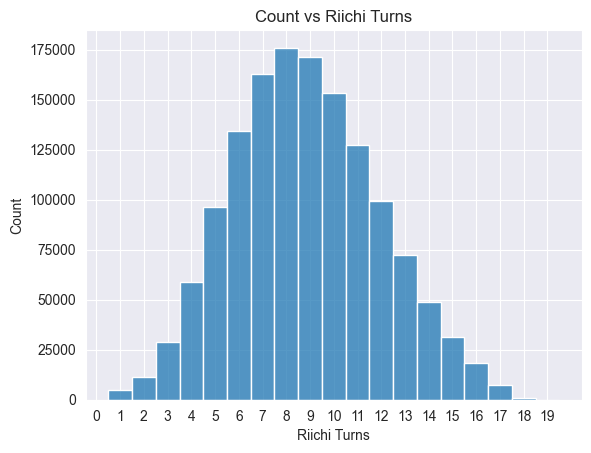

In [22]:
bins = [i for i in range(20)]

sns.histplot(df["num_discards"], bins=bins, discrete=True)
plt.xlabel("Riichi Turns")
plt.ylabel("Count")
plt.title("Count vs Riichi Turns")
plt.xticks(bins)
plt.show()

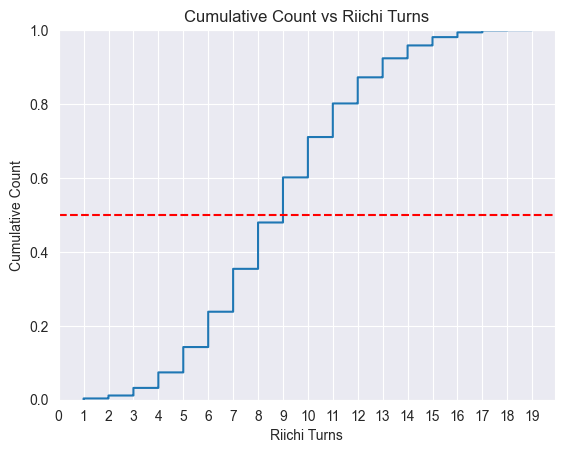

In [23]:
bins = [i for i in range(20)]
sns.ecdfplot(data=df["num_discards"], stat="proportion")
plt.xlabel("Riichi Turns")
plt.ylabel("Cumulative Count")
plt.title("Cumulative Count vs Riichi Turns")
plt.xticks(bins)
plt.axhline(0.5, color='red', linestyle='--')

plt.show()

## Proximate Tile Deal In Rate

In this section, we investigate the deal in rate for tiles close to the riichi tile vs tiles far from the riichi tiles. 

Our question is: Given a person in riichi, how dangerous is it to drop a tile close to the riichi tile? To investigate this, we calculate the deal in rate for a tile (# of times a tile deals in / # of riichis) post riichi. For an arbitrary tile, we will compare the deal in rate for the tile and the deal in rate for the tile(s) corresponding to the same number but not in the same suit. 

If there is no significant difference between the deal in rates, then we would expect that each group would have roughly the same deal in rate. Otherwise, we would expect there to be a much higher/lower deal in rate. 

Due to the symmetry of Mahjong Hands, we are able to remain suit-agnostic when conducting our analysis. Tsuuiisou is not relevant enough to detract from this fact. 

We will also only compare non-jihai tiles.

In [90]:
# DF Cleaning

# df = df[df.tile < 27].reset_index(drop=True)  # Removing jihai riichi
# df["tile_type"] = df["tile"] % 9  # Riichi tile type
# df["tile_suit"] = df["tile"] // 9  # Riichi tile suit

In [18]:
# Calculations

def calculate_dealin_rates(DF=df):
    arr = DF.groupby("tile")[[f"{i}_ron" for i in range(27)]].mean().transpose().to_numpy()
    arr[9:18, :] = (arr[9:18, :] + arr[18:, :]) / 2
    return np.stack([arr[:9], arr[9:18]], axis=-1)

In [ ]:
dealin_rates_all = calculate_dealin_rates()

In [19]:
print("Copy Pasteable - Same Suit")
print("\n".join("\t".join(map(str, i[:, 0] * 100)) for i in dealin_rates_all))
print("Copy Pasteable - Different Suit")
print("\n".join("\t".join(map(str, i[:, 1] * 100)) for i in dealin_rates_all))

Copy Pasteable - Same Suit
0.12702144197774282	7.096490262955221	6.281015355036504	1.222545423886008	4.775576783016426	4.367059020534039	3.6081065250497875	4.362921716344579	4.277164818333948
8.326539898003677	0.04620970403784795	5.767232196211905	6.67622219411773	3.5825854565810147	6.423951494177488	5.5670532495086364	5.191978745860174	5.440999896001739
7.685745160862228	6.973997872886639	0.03377588401881057	5.679917934881891	6.840137958431897	5.1806060436915224	7.302771161180314	6.345670924773447	6.292840192491325
6.02593512427247	9.858803682106576	9.32993842396529	0.05550637269367509	8.422566917664337	7.844519023464483	5.434287424993817	8.624667904065218	8.021102192472416
8.891500938441997	5.804085524626839	9.396191119540648	9.11990781726459	0.03310520835214311	9.280436496584638	9.265622762830777	5.762637842559231	9.04595777670628
8.221320643828085	8.712362929548538	5.466496921198265	8.037182243581636	8.414140137356519	0.044654382060102006	9.292956903172062	9.652436583324235	5.96571

We will now perform a hypothesis test using bootstrapping on these samples. Our $H_0$ is that the deal in rate for (same vs different) suit is the same, and our $H_a$  is that the deal in rate for (same vs different) suit is different.

In [54]:
def bootstrap(DF=df, B=10000, n=2000):
    bootstraps = []

    for _ in tqdm(range(B), leave=False):
        indices = np.random.choice(DF.shape[0], size=n, replace=True)
        bootstrap_sample = DF.iloc[indices].reset_index(drop=True)

        differences = calculate_dealin_rates(bootstrap_sample)
        bootstraps.append(differences[:, :, 0] - differences[:, :, 1])

    return np.stack(bootstraps, axis=-1)


def bootstrap_hypothesis_test(DF=df, DR=dealin_rates_all, B=10000, n=2000):
    observed_diff = DR[:, :, 0] - DR[:, :, 1]
    
    # 30k per sample idk man
    bootstrap_diffs = bootstrap(B=B, DF=DF, n=n)

    ci_lower = np.percentile(bootstrap_diffs, 2.5, axis=2)
    ci_upper = np.percentile(bootstrap_diffs, 97.5, axis=2)

    bootstrap_diffs_null = bootstrap_diffs - np.mean(bootstrap_diffs, axis=2, keepdims=True)
    p_values = np.mean(np.abs(bootstrap_diffs_null) >= np.abs(observed_diff[:, :, np.newaxis]), axis=2)
    # p_values = np.mean(np.abs(bootstrap_diffs) >= np.abs(observed_diff[:, :, np.newaxis]), axis=2)
    hyp_test = (ci_lower > 0) | (ci_upper < 0)

    return [[{
        'observed_diff': observed_diff[i, j],
        'bootstrap_mean': np.mean(bootstrap_diffs[i, j]),
        'bootstrap_std': np.std(bootstrap_diffs[i, j]),
        'ci_95': (ci_lower[i, j], ci_upper[i, j]),
        'p_value': p_values[i, j],
        'reject_H0': hyp_test[i, j]
    } for j in range(9)] for i in range(9)]


In [55]:
test_results = bootstrap_hypothesis_test(B=10000, n=30000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [56]:
significance_all = [[j["reject_H0"] for j in i] for i in test_results]
print("\n".join("\t".join(map(str, i)) for i in significance_all))

True	True	True	True	False	False	False	False	False
True	True	False	False	True	False	False	False	False
False	False	True	True	False	True	False	False	False
True	False	False	True	False	False	True	False	False
False	True	False	False	True	False	False	True	False
False	False	True	False	False	True	False	False	True
False	False	False	True	False	True	True	False	False
False	False	False	False	True	False	False	True	True
False	False	False	False	False	True	True	True	True


Next, we investigate how these stats are impacted for different types of riichis 

- An early riichi is defined to be a riichi during turns 1-6.
- A normal riichi is defined to be a riichi during turns 7-12
- A late riichi is defined to be a riichi during turns 13-end.

In [59]:
early_riichi = df[df.num_discards <= 6]
normal_riichi = df[(7 <= df.num_discards) & (df.num_discards <= 12)]
late_riichi = df[df.num_discards >= 13]

In [62]:
dealin_rates_early = calculate_dealin_rates(early_riichi)
test_results_early = bootstrap_hypothesis_test(DF=early_riichi, DR=dealin_rates_early)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [143]:
print("Same Suit")
print("\n".join("\t".join(map(str, i[:, 0] * 100)) for i in dealin_rates_early))
print("Different Suit")
print("\n".join("\t".join(map(str, i[:, 1] * 100)) for i in dealin_rates_early))
print("Signifigance")
print("\n".join("\t".join(map(str, i)) for i in [[j["reject_H0"] for j in i] for i in test_results_early]))

Same Suit
0.1317891373801917	6.147761998921445	5.07303077725613	1.6287502193110708	4.745463709677419	4.527116592703591	3.875320328434705	4.4860653281390475	4.5105722916156425
7.092651757188498	0.04493978069387022	4.001043296817945	5.248844961693666	4.057459677419355	5.803700074923635	5.4285863710057	5.013485166317051	5.343293330067761
6.122204472843451	4.964347773982863	0.023474178403755867	4.123048131469677	5.496471774193548	5.328223157166734	6.294126876209403	5.963440215762661	5.686178463548044
4.704472843450479	7.639762717957936	6.7240479916536255	0.04678636177554243	6.549899193548388	6.599043282807908	4.994508655405052	7.659574468085106	7.355702506327047
7.567891373801918	4.68871711906046	7.402190923317684	6.909760804725422	0.015120967741935484	6.748890553858568	6.929553893624811	4.477075217261013	7.633276185811087
7.663738019169329	7.810533884594643	4.833072509128847	6.7109187671793675	6.539818548387097	0.028816782894357674	6.639297107891847	7.503745879532514	4.473834598742755
5.7

In [63]:
dealin_rates_normal = calculate_dealin_rates(normal_riichi)
test_results_normal = bootstrap_hypothesis_test(DF=normal_riichi, DR=dealin_rates_normal)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [64]:
print("Same Suit")
print("\n".join("\t".join(map(str, i[:, 0] * 100)) for i in dealin_rates_normal))
print("Different Suit")
print("\n".join("\t".join(map(str, i[:, 1] * 100)) for i in dealin_rates_normal))
print("Signifigance")
print("\n".join("\t".join(map(str, i)) for i in [[j["reject_H0"] for j in i] for i in test_results_normal]))

Same Suit
0.1212300413956239	7.602803738317757	6.848333108241479	1.1018977127274752	4.774306371696393	4.311737754266363	3.5369375524019504	4.383967074002566	4.256848963301002
8.490538143110586	0.037383177570093455	6.272790550297641	7.0766319772942285	3.562395991011743	6.472033466876203	5.47257501889058	5.209429228759379	5.430747333049641
7.968657599053815	7.244158878504672	0.030127679025940973	5.892370193110357	7.119150816558702	5.253547001925673	7.4475462948586575	6.396753644635074	6.347855434415766
6.246303962152573	10.385514018691588	9.923434139854765	0.05787745561800879	8.795517153843985	8.04798689656699	5.47153991864112	8.763309710163359	8.108702989038724
8.947368421052632	5.982476635514019	9.795651225365427	9.445155545661974	0.034787187032840984	9.701409947099314	9.777556956391226	5.98171034833578	9.219504321413375
8.287995269071555	8.738317757009346	5.565309535929854	8.22416383772052	8.828423952388563	0.040948228159100465	9.964910101543333	10.25122258575442	6.22753085151653
6.40

In [65]:
dealin_rates_late = calculate_dealin_rates(late_riichi)
test_results_late = bootstrap_hypothesis_test(DF=late_riichi, DR=dealin_rates_late)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [66]:
print("Same Suit")
print("\n".join("\t".join(map(str, i[:, 0] * 100)) for i in dealin_rates_late))
print("Different Suit")
print("\n".join("\t".join(map(str, i[:, 1] * 100)) for i in dealin_rates_late))
print("Signifigance")
print("\n".join("\t".join(map(str, i)) for i in [[j["reject_H0"] for j in i] for i in test_results_late]))

Same Suit
0.14827532386452316	6.423921184536498	5.852575029701947	1.0556254444019035	4.841759554140127	4.336636916169304	3.4303036749454874	4.024432012786848	3.946967387991466
9.872014983611676	0.09218182865702598	6.75138178624929	7.378438987037137	2.751791401273885	7.3646169851612555	6.334095623038877	5.445827149217948	5.676622980798537
9.247697830497893	9.506251080255804	0.07231778500955628	7.547995405568014	8.016520700636942	4.539232327657011	8.610328139126736	6.82155497202877	7.139591587930509
7.444982050881848	11.528489946419313	11.539852265096338	0.0601651807690204	10.146297770700636	9.204402343536112	6.137318513003244	9.77851352894166	8.808290155440414
11.183081005150616	7.06919398513568	11.359057802572448	11.655636383525678	0.059713375796178345	12.007884794393036	11.386480880710526	7.129809338965636	10.781773849436147
8.958951147182768	10.318603445295846	6.229660622966062	9.5990811136028	9.922372611464967	0.09308437825110881	11.237568473115992	10.788902842790273	7.3910393172813